In [1]:
!pip install schedule

Requirement not upgraded as not directly required: schedule in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages


In [2]:
import time
import math
import requests
import schedule
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.models import model_from_json
from sklearn.metrics import mean_squared_error
from datetime import datetime 
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

Using TensorFlow backend.


In [3]:
def get_prediction(companyname, interval):
    response = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol="+companyname+"&interval="+interval+"&apikey=UDG3SY9XVL8GU95E&outputsize=full&datatype=csv")
    response.text
    file = open("response.csv", "w")
    file.write(response.text)
    file.close()  
    df = pd.read_csv("response.csv")
    df=df[::-1]
    
    df.plot(x=df.timestamp, y='close',figsize=(20,15))
    plt.title('History')
    plt.ylabel('Price (USD)')
    plt.xlabel('Minutes')
    plt.legend(['Close'], loc='upper left')
    plt.show()
    
    df.plot(x=df.timestamp, y='volume',figsize=(20,15))
    plt.title('Stock volume history')
    plt.ylabel('volume')
    plt.xlabel('Minutes')
    plt.show()
    
    df.set_index('timestamp', inplace=True)
    
    # take close column of dataframe since we will use it for prediction
    df["close"] = pd.to_numeric(df["close"])
    df = df[["close"]]
    
    # put the last 20 percent of data to the test dataframe
    df_train=df[0:round(len(df)*0.8)]
    df_test=df.drop(df_train.index)
    
    
    
    # change dataframe to numpy array
    train = df_train.values 
    test = df_test.values
    
    # normalize the data 
    scaler = MinMaxScaler(feature_range = (-1, 1))
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    
    
    
    # divide train or test arrays into feature and target arrays
    def create_dataset(dataset, window_size):
        x, y = [], []
        for i in range(len(dataset) - window_size - 1):
            x.append(dataset[i:(i + window_size), 0])
            y.append(dataset[i + window_size, 0])
        return(np.array(x), np.array(y))
    window_size = 50
    
    x_train, y_train = create_dataset(train, window_size)
    x_test, y_test = create_dataset(test, window_size)
    
    # reshape x_train and x_test to 3D shape for LSTM
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
    
    EPOCHS = 20 # you can increase epochs number for better prediction
    # create a model
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
    model.fit(x_train, y_train, epochs = EPOCHS, batch_size = 32, callbacks=[early_stop])

    
    def predict_and_score(model, X, Y):
        pred = scaler.inverse_transform(model.predict(X))
        orig_data = scaler.inverse_transform([Y])
        score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
        return(score, pred)

    rmse_train, train_predict = predict_and_score(model, x_train, y_train)
    rmse_test, test_predict = predict_and_score(model, x_test, y_test)
    print("Training data score: %.2f RMSE" % rmse_train)
    print("Testing data score: %.2f RMSE" % rmse_test)
    print(train_predict)
    print(test_predict)    
    
    train_predict_plot = np.empty_like(df)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[window_size:len(train_predict)+window_size, :] = train_predict
    
    # Add test predictions.
    test_predict_plot = np.empty_like(df)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict)+(window_size*2)+1: len(df)-1, :] = test_predict
    
    
    # Create the plot.
    df.plot(x=df.index, y='close',figsize=(20,15))
    plt.plot(train_predict_plot, label = "Training set prediction")
    plt.plot(test_predict_plot, label = "Test set prediction")
    plt.ylabel("Closing Values of Company")
    plt.title("Comparison true vs. predicted training / test")
    plt.legend()
    plt.show()
    
    

    

company name?: IBM
interval?: 1min


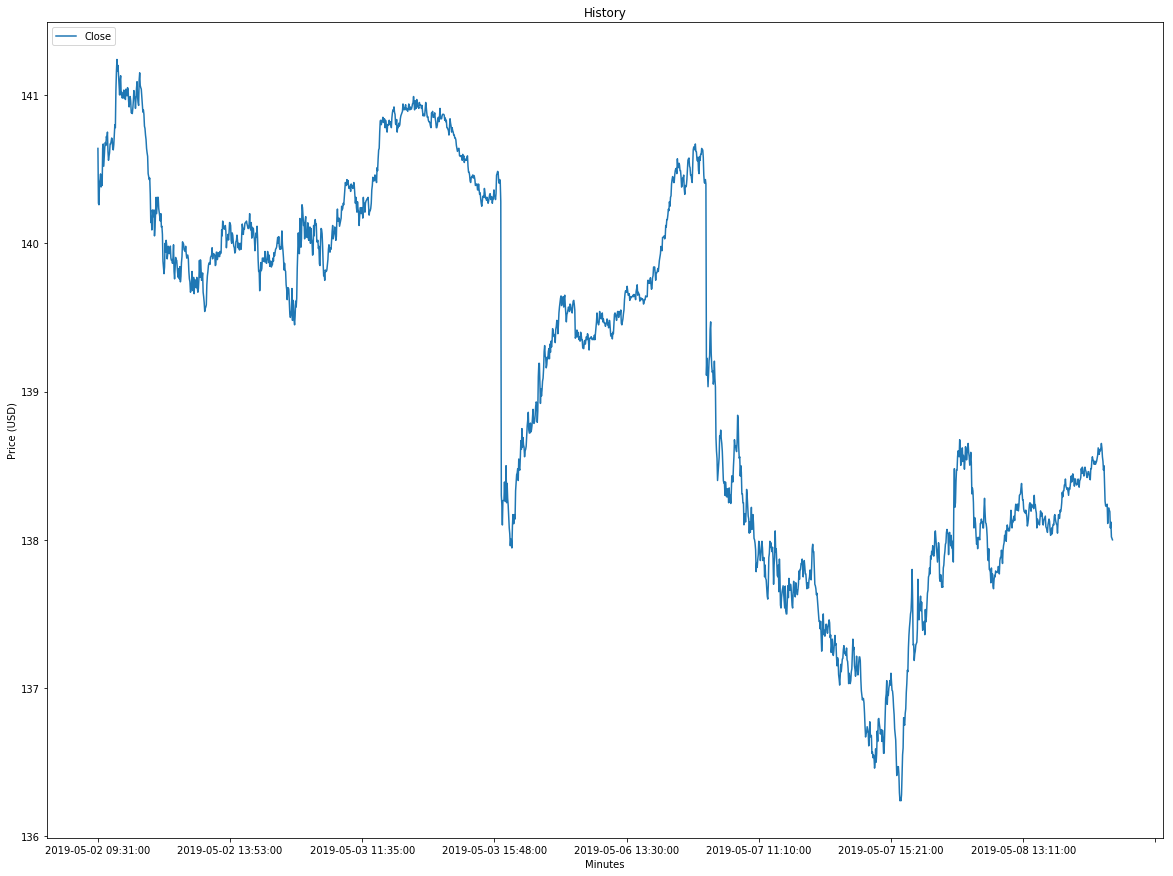

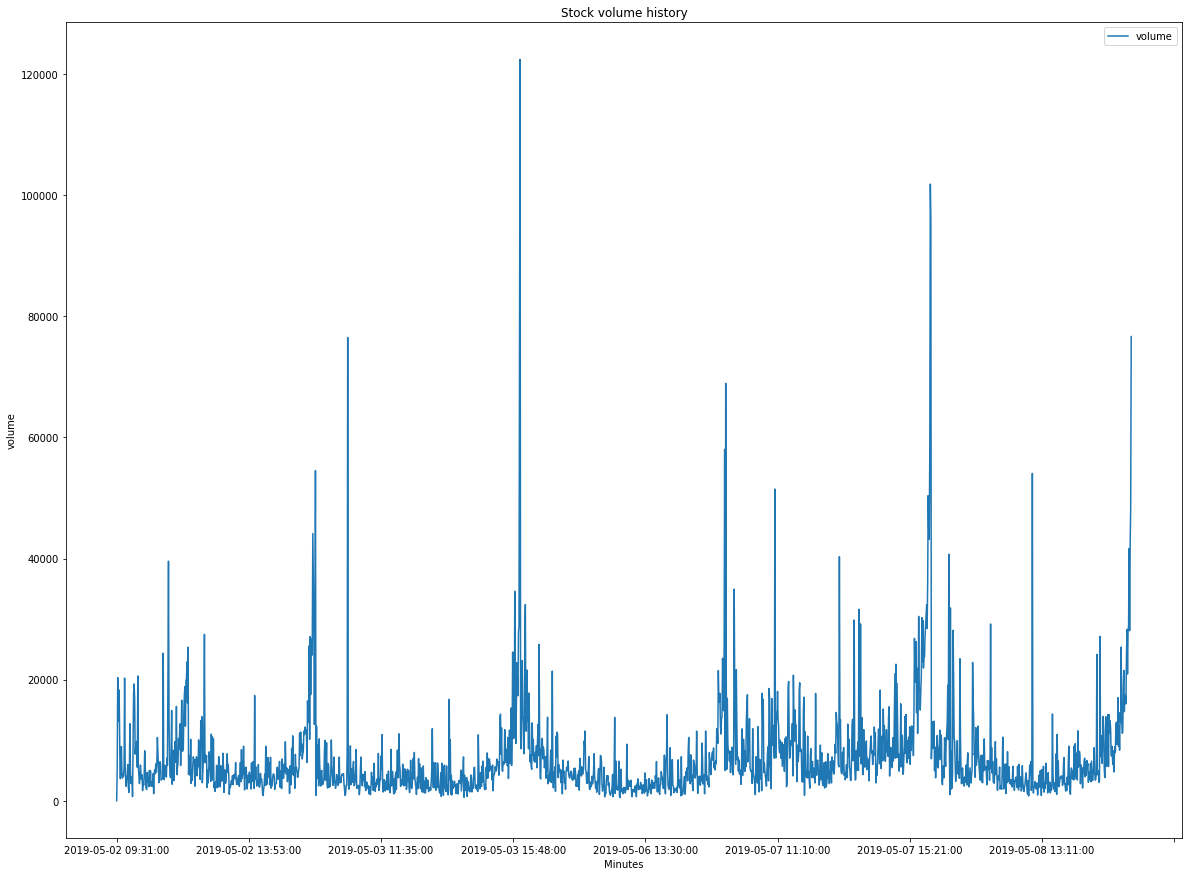

Epoch 1/20
1485/1485 [==============================] - 24s 16ms/step - loss: 0.0640
Epoch 2/20
1485/1485 [==============================] - 24s 16ms/step - loss: 0.0147
Epoch 3/20
1485/1485 [==============================] - 24s 16ms/step - loss: 0.0133
Epoch 4/20
1485/1485 [==============================] - 24s 16ms/step - loss: 0.0120
Epoch 5/20
1485/1485 [==============================] - 24s 16ms/step - loss: 0.0112
Epoch 6/20
1485/1485 [==============================] - 24s 16ms/step - loss: 0.0112
Epoch 7/20
1485/1485 [==============================] - 24s 16ms/step - loss: 0.0104
Epoch 8/20
1485/1485 [==============================] - 24s 16ms/step - loss: 0.0104
Epoch 9/20
1485/1485 [==============================] - 24s 16ms/step - loss: 0.0094
Epoch 10/20
1485/1485 [==============================] - 24s 16ms/step - loss: 0.0098
Epoch 11/20
1485/1485 [==============================] - 24s 16ms/step - loss: 0.0089
Epoch 12/20
1485/1485 [==============================] - 24s 16

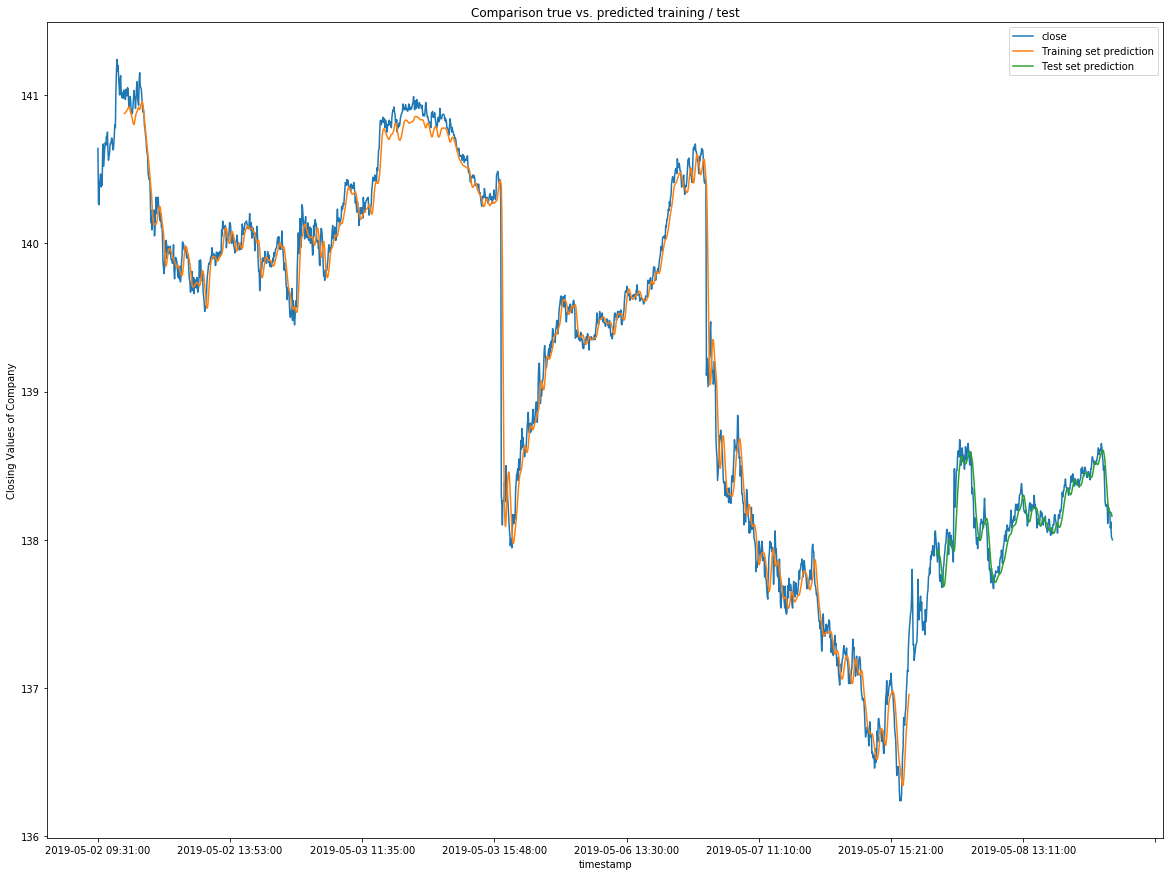

In [ ]:
def job():
    companyname = input("company name?: ")
    interval=input("interval?: ")
    data = get_prediction(companyname,interval)


schedule.every(10).seconds.do(job) 


while True:
    schedule.run_pending()
    time.sleep(1)